## Hirunya Hirunsirisombut
## CSC 578 Final Project Part A

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten,LSTM,RepeatVector,Bidirectional,Activation,GRU,BatchNormalization,SimpleRNN
import warnings
warnings.filterwarnings("ignore")

In [2]:
traffic = pd.read_csv("Metro_Interstate_Traffic_volume.csv") 

In [3]:
d_t = pd.to_datetime(traffic.pop('date_time'),  format='%Y-%m-%d %H:%M:%S')  

In [4]:
traffic.head()  

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


## Exploratory Data Analysis

#### The evolution of column, rain_1h columns, snow_1h column, clouds_all column, and traffic_volume over the time

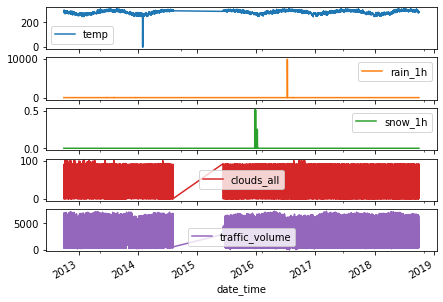

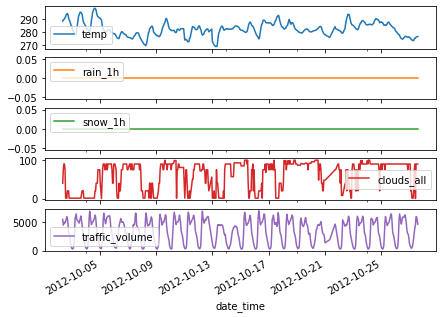

In [5]:
mpl.rcParams['figure.figsize'] = (7, 5)                             

p_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']                
p_feat = traffic[p_cols]                                                 
p_feat.index = d_t                                                      
pp = p_feat.plot(subplots=True)                                         

p_feat = traffic[p_cols][:700]                                      
p_feat.index = d_t[:700]                                           
pp = p_feat.plot(subplots=True)                                    

#### Examine the histograms illustrating the distribtions of numeric attributes, and the characteristics. Also, the bar graphs

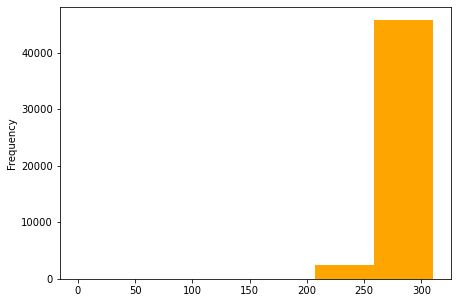

In [6]:
traffic["temp"].plot(kind="hist", bins=6, color='orange')  

The histogram shows the frequency of the temp column. It shows that the most frequency of the temprerature is approximately around 260 until 300

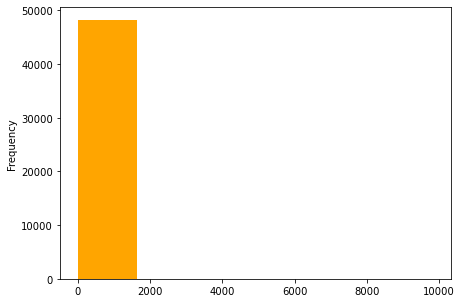

In [7]:
traffic["rain_1h"].plot(kind="hist", bins=6, color='orange') 

The histogram shows the frequency of the rain_1h column. It shows that the most frequency of the rain is approximately around 0 until 9800 mm for last hour

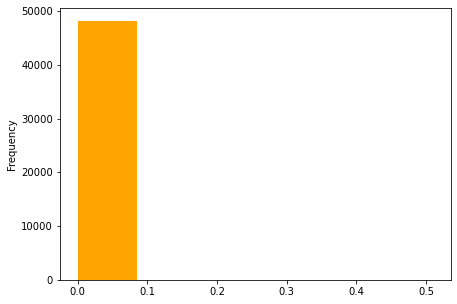

In [8]:
traffic["snow_1h"].plot(kind="hist", bins=6, color='orange') 

The histogram shows the frequency of the snow_1h column. It shows that the most frequency of the snow is 0. it is clearly that snow has only 0 mm for last hour.

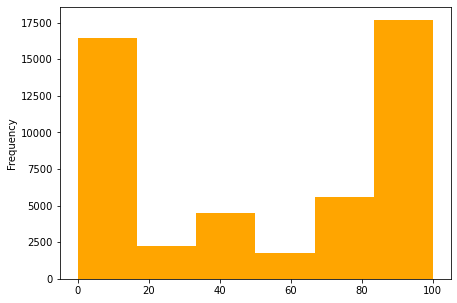

In [9]:
traffic["clouds_all"].plot(kind="hist", bins=6, color='orange') 

The histogram shows the frequency of the clouds_all column. It shows that the most frequency of the cloud is apporximately around 85 to 100 percent.

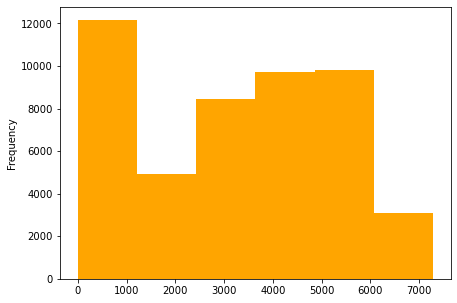

In [10]:
traffic["traffic_volume"].plot(kind="hist", bins=6, color='orange') 

The histogram shows the frequency of the traffic_volumn column. It shows that the most frequency of the number of the car start with approximately around 0 until 1100.

#### The bar graph

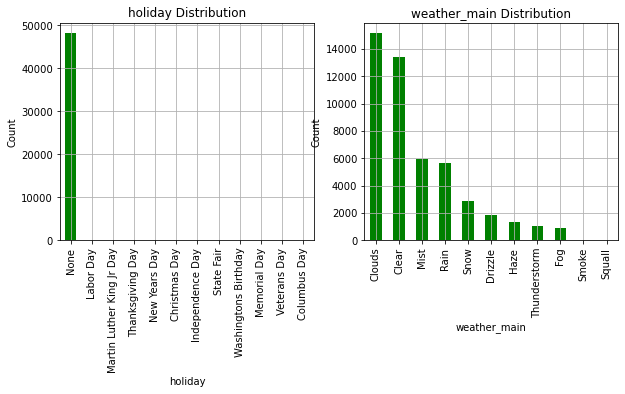

In [11]:
holiday = traffic["holiday"].value_counts()                 
wea_main = traffic["weather_main"].value_counts()         

fig = plt.figure(figsize=(10,4))                           
myP = fig.add_subplot(121)                                 
myP.set_xlabel('holiday')                                  
myP.set_ylabel('Count')                                    
myP.set_title("holiday Distribution")                       
holiday.plot(kind='bar', color = 'green', grid = True)   

myP = fig.add_subplot(122)                                  
myP.set_xlabel('weather_main')                          
myP.set_ylabel('Count')                                     
myP.set_title("weather_main Distribution")                  
wea_main.plot(kind='bar', color = 'green',grid = True)     

the bar graph of holiday and weather_main.
The holiday graph shows that 'None' is the most count value, and the weather_main shows that 'Clouds' is the most count value.

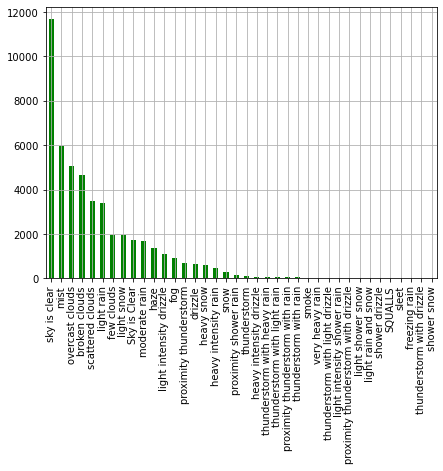

In [12]:
temp3 = traffic["weather_description"].value_counts()   
myP = fig.add_subplot(122)                            
myP.set_xlabel('weather_description')                   
myP.set_ylabel('Count')                               
myP.set_title("weather_description Distribution")     
temp3.plot(kind='bar', color = 'green', grid = True)   

the bar graph of weather description column.
The weather description graph shows that 'sky is clear' is the most count value.

#### The statistic of the data set

In [8]:
traffic.describe().T             

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00


#### Coverting the time column format

In [479]:
time_s = d_t.map(datetime.datetime.timestamp)  

#### Using sin and cos to convert the time for time of the day and also time of the year

In [480]:
tempdays = 24*60*60            
tempyears = (365.2425)*tempdays  

traffic['Day sin'] = np.sin(time_s * (2 * np.pi / tempdays))  
traffic['Day cos'] = np.cos(time_s * (2 * np.pi / tempdays))  
traffic['Year sin'] = np.sin(time_s * (2 * np.pi / tempyears))
traffic['Year cos'] = np.cos(time_s * (2 * np.pi / tempyears)) 

In [481]:
data = traffic[['traffic_volume','temp', 'rain_1h', 'snow_1h', 'clouds_all','Day sin',
       'Day cos', 'Year sin', 'Year cos']]                                              

#### Spilt train and test dataset in this case 70% for training, 20% for validation and 10% for testing.
#### Accoring to the tensorflow.org tutorials.

In [482]:
colIndice = {}                                                                          
for value, TempName in enumerate(data.columns):       
    colIndice[TempName] = value                       
tempNum = len(data)                                   
train_data = data[0:int(tempNum*0.7)]                 
valid_data = data[int(tempNum*0.7):int(tempNum*0.9)] 
test_data = data[int(tempNum*0.9):]                   

temp_feature = data.shape[1]                          

In [483]:
train_data.shape, valid_data.shape, test_data.shape  

((33742, 9), (9641, 9), (4821, 9))

#### Normalize the data

In [484]:
TempTrain_mean = train_data.mean()  
TempTrain_std = train_data.std()    

train_data = (train_data - TempTrain_mean) / TempTrain_std 
valid_data = (valid_data - TempTrain_mean) / TempTrain_std  
test_data = (test_data - TempTrain_mean) / TempTrain_std    

#### Creating the window generator follow from tutorial tensorflow

In [485]:
class Generator():                                                        
    
    def __init__(self, input_w, label_w, DTshift,                           
        train_data=train_data, valid_data=valid_data, test_data=test_data,  
        name_col=None):                                                     

        self.train_data = train_data                                        
        self.valid_data = valid_data                                      
        self.test_data = test_data                                          

        self.name_col = name_col                                           
         
        if name_col is not None:                                       
            self.name_col_idx = {}                                    
            for value, TempName in enumerate(name_col):                 
                self.name_col_idx[TempName] = value                  
        self.col_idx = {}                                               
        for value, TempName in enumerate(train_data.columns):           
            self.col_idx[TempName] = value                          
                                                                             
        self.input_w = input_w                                          
        self.label_w = label_w                                          
        self.DTshift = DTshift                                          

        self.windowdim = input_w + DTshift                             

        self.in_cut = slice(0, input_w)                        
                                                               
        self.in_idx = np.arange(self.windowdim)[self.in_cut] 
                                                              
        self.lbl_cut = slice(self.windowdim - self.label_w, None)  
                                                                
        self.lbl_idx = np.arange(self.windowdim)[self.lbl_cut] 
                                                               

    def __repr__(self):                                
        return '\n'.join([                             
            f'Total window size: {self.windowdim}',    
            f'Input indices: {self.in_idx}',          
            f'Label indices: {self.lbl_idx}',          
            f'Label column name: {self.name_col}'])    

#### Function split for input and their name

In [486]:

def WindowDivide(self, feat):                      
    myInput = feat[:, self.in_cut, :]            
    myLabel = feat[:, self.lbl_cut, :]            
    if self.name_col is not None:                   
        myLabel = tf.stack([myLabel[:, :, self.col_idx[TempName]] 
                    for TempName in self.name_col],axis=-1)      
    myInput.set_shape([None, self.input_w, None]) 
    myLabel.set_shape([None, self.label_w, None])   

    return myInput, myLabel                      

Generator.WindowDivide = WindowDivide  

#### Function for making the data and return these parameters

In [487]:
def CreateDT(self, DT):                
    DT = np.array(DT, dtype=np.float32)
    mySet = timeseries_dataset_from_array(  
                                                  
      data = DT,                                  
      targets=None,                               
      sequence_length = self.windowdim,          
      sequence_stride = 1,                      
      shuffle=False,                            
      batch_size=32,)                            

    mySet = mySet.map(self.WindowDivide)           

    return mySet                                  

Generator.CreateDT = CreateDT                     

#### Collecting the object into property and then return these values

In [488]:
@property
def train(self):                             
    return self.CreateDT(self.train_data)    

@property
def val(self):                               
    return self.CreateDT(self.valid_data)    

@property
def test(self):                                                      
    return self.CreateDT(self.test_data)    
@property
def example(self):                           
    res = getattr(self, '_example', None)  
                                            
    if res is None:                        
        res = next(iter(self.train))        
        self._example = res                
    return res                               

Generator.train = train                      
Generator.val = val                       
Generator.test = test                       
Generator.example = example                

## Base model

In [489]:
window = Generator(                
    input_w=6, label_w=1, DTshift=3, 
    name_col=['traffic_volume'])   

window                          

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [8]
Label column name: ['traffic_volume']

In [494]:
model1 = Sequential()                        
model1.add(LSTM(128, return_sequences=True)) 
model1.add(Dropout(0.1))                   
model1.add(LSTM(64, return_sequences=True))  
model1.add(Dense(1))                        

In [495]:
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss' 
                , patience=10, mode='min') 

In [496]:
model1.compile(loss=tf.losses.MeanSquaredLogarithmicError(), 
                  optimizer=tf.optimizers.Adam(),            
                  metrics=[tf.metrics.MeanAbsoluteError()])  

In [497]:
print('Input shape:', window.example[0].shape)           
print('Output shape:', model1(window.example[0]).shape)  

Input shape: (32, 6, 9)
Output shape: (32, 6, 1)


In [498]:
history = model1.fit(window.train, epochs = 30, batch_size = 32,    
            validation_data=window.val, callbacks=[early_stopping1]) 

Epoch 1/30
1055/1055 [==============================] - 8s 7ms/step - loss: 0.0690 - mean_absolute_error: 0.6778 - val_loss: 0.0584 - val_mean_absolute_error: 0.6513
Epoch 2/30
1055/1055 [==============================] - 8s 7ms/step - loss: 0.0587 - mean_absolute_error: 0.5971 - val_loss: 0.0501 - val_mean_absolute_error: 0.5664
Epoch 3/30
1055/1055 [==============================] - 7s 7ms/step - loss: 0.0543 - mean_absolute_error: 0.5798 - val_loss: 0.0444 - val_mean_absolute_error: 0.5526
Epoch 4/30
1055/1055 [==============================] - 8s 7ms/step - loss: 0.0514 - mean_absolute_error: 0.5703 - val_loss: 0.0426 - val_mean_absolute_error: 0.5260
Epoch 5/30
1055/1055 [==============================] - 8s 7ms/step - loss: 0.0491 - mean_absolute_error: 0.5648 - val_loss: 0.0416 - val_mean_absolute_error: 0.5323
Epoch 6/30
1055/1055 [==============================] - 7s 7ms/step - loss: 0.0474 - mean_absolute_error: 0.5630 - val_loss: 0.0405 - val_mean_absolute_error: 0.5280
Epoc

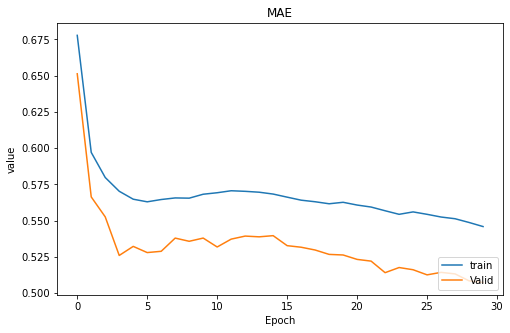

In [499]:

plt.figure(figsize=(8, 5))
plt.title('MAE')
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(loc='lower right')
plt.show()

In [500]:
mytest = test_data.iloc[8:]  

In [501]:
myDim = np.expand_dims(mytest, axis=0)

In [505]:
predictions1 = model1.predict(myDim)

In [506]:
temp0 = predictions1.shape[0]    
temp1 = predictions1.shape[1]   
temp2 = predictions1.shape[2]   
p1 = predictions1.reshape((temp1, temp0 * temp2))  
p1.shape                                           

(4813, 1)

In [507]:
p1 

array([[ 0.15300697],
       [ 0.7145269 ],
       [ 0.75987875],
       ...,
       [-0.5368642 ],
       [-0.594569  ],
       [-0.5679952 ]], dtype=float32)

In [508]:
Dnorm = (p1 * TempTrain_std[0]) + TempTrain_mean[0]   
                                                     
Dnorm.shape

(4813, 1)

In [510]:
res1 = Dnorm.flatten()    
myres = zip()            
finalRes = []             
myres = zip(mytest.iloc[:,0].index , res1)  
finalRes = list(myres)                        
model1 = pd.DataFrame(finalRes, columns = ['id', 'prediction'])  
model1.head()         

,id,prediction
0,43391,3545.121582
1,43392,4663.463379
2,43393,4753.787598
3,43394,5012.832031
4,43395,4777.017578


In [511]:
model1.to_csv('kaggle1.csv', index=False)  

## Model 2 change loss function to Mean Square Error and add more LSTM layer

In [131]:
model2 = Sequential()                        
model2.add(LSTM(128, return_sequences=True)) 
model2.add(Activation('relu'))               
model2.add(LSTM(64, return_sequences=True))  
model2.add(Activation('linear'))             
model2.add(Dropout(0.1))                    
model2.add(LSTM(32,return_sequences=True))   
model2.add(Dense(1))                         

In [132]:
early_stopping2 = tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss'                
                ,patience=5, mode='min')          

In [133]:
model2.compile(loss=tf.losses.MeanSquaredError(),     
                optimizer=tf.optimizers.Adam(),          
                metrics=[tf.metrics.MeanAbsoluteError()]) 

In [134]:
print('Input shape:', window.example[0].shape)         
print('Output shape:', model2(window.example[0]).shape) 

Input shape: (32, 6, 9)
Output shape: (32, 6, 1)


In [135]:
history2 = model2.fit(window.train, epochs = 30, batch_size = 32,   
         validation_data = window.val, callbacks=[early_stopping2])

Epoch 1/30
1055/1055 [==============================] - 10s 9ms/step - loss: 0.4933 - mean_absolute_error: 0.5358 - val_loss: 0.3493 - val_mean_absolute_error: 0.4443
Epoch 2/30
1055/1055 [==============================] - 10s 9ms/step - loss: 0.4022 - mean_absolute_error: 0.4647 - val_loss: 0.3179 - val_mean_absolute_error: 0.4156
Epoch 3/30
1055/1055 [==============================] - 10s 9ms/step - loss: 0.3707 - mean_absolute_error: 0.4397 - val_loss: 0.2926 - val_mean_absolute_error: 0.3908
Epoch 4/30
1055/1055 [==============================] - 9s 9ms/step - loss: 0.3470 - mean_absolute_error: 0.4204 - val_loss: 0.2740 - val_mean_absolute_error: 0.3733
Epoch 5/30
1055/1055 [==============================] - 9s 9ms/step - loss: 0.3324 - mean_absolute_error: 0.4080 - val_loss: 0.2614 - val_mean_absolute_error: 0.3625
Epoch 6/30
1055/1055 [==============================] - 9s 9ms/step - loss: 0.3223 - mean_absolute_error: 0.3992 - val_loss: 0.2550 - val_mean_absolute_error: 0.3556
E

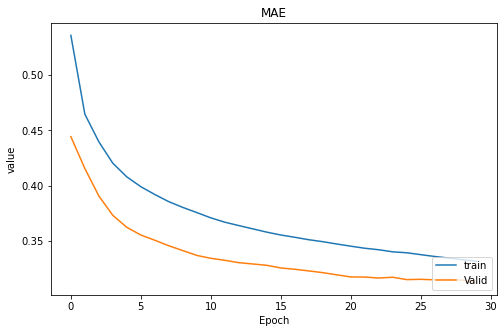

In [137]:

plt.figure(figsize=(8, 5))
plt.title('MAE')
plt.plot(history2.history['mean_absolute_error'], label='train') 
plt.plot(history2.history['val_mean_absolute_error'], label='Valid') 
plt.xlabel('Epoch')  
plt.ylabel('value')
plt.legend(loc='lower right')
plt.show()

In [138]:
mytest2 = test_data.iloc[8:]  

In [139]:
myDim2 = np.expand_dims(mytest2, axis=0)  

In [140]:
predictions2 = model2.predict(myDim2) 

In [141]:
temp0 = predictions2.shape[0]    
temp1 = predictions2.shape[1]    
temp2 = predictions2.shape[2]    
p2 = predictions2.reshape((temp1, temp0 * temp2))  
p2.shape 

(4813, 1)

In [142]:
norm2 = (p2 * TempTrain_std[0]) + TempTrain_mean[0]   

norm2.shape

(4813, 1)

In [143]:
res2 = norm2.flatten()   
myres2 = zip()       
finalRes2 = []           
myres2 = zip(mytest2.iloc[:,0].index , res2)   
finalRes2 = list(myres2)                       
model2 = pd.DataFrame(finalRes2, columns = ['id', 'prediction'])
model2.head()                             

,id,prediction
0,43391,2120.577637
1,43392,5019.817383
2,43393,5152.572754
3,43394,5923.529297
4,43395,5889.802734


In [144]:
model2.to_csv('kaggle2.csv', index=False)   

## Model 3 change to Bidirectional RNNs

In [261]:
model3 = Sequential()                                        
model3.add(Bidirectional(LSTM(128, return_sequences=True)))  
model3.add(Activation('relu'))                               
model3.add(Bidirectional(LSTM(64, return_sequences=True)))   
model3.add(Activation('linear'))                             
model3.add(Dropout(0.2))                                    
model3.add(Bidirectional(LSTM(32, return_sequences=True)))   
model3.add(Dense(1))                                        

In [262]:
early_stopping3 = tf.keras.callbacks.EarlyStopping(        
            monitor='val_loss', patience=10, mode='min')   

In [263]:
model3.compile(loss=tf.losses.MeanSquaredError(),      
                optimizer=tf.optimizers.Adam(),          
                metrics=[tf.metrics.MeanAbsoluteError()]) 

In [264]:
print('Input shape:', window.example[0].shape)           
print('Output shape:', model3(window.example[0]).shape) 

Input shape: (32, 6, 9)
Output shape: (32, 6, 1)


In [265]:
history3 = model3.fit(window.train, epochs=30,batch_size = 32,       
           validation_data=window.val, callbacks=[early_stopping3]) 

Epoch 1/30
1055/1055 [==============================] - 16s 15ms/step - loss: 0.3487 - mean_absolute_error: 0.4286 - val_loss: 0.2324 - val_mean_absolute_error: 0.3558
Epoch 2/30
1055/1055 [==============================] - 16s 15ms/step - loss: 0.2582 - mean_absolute_error: 0.3538 - val_loss: 0.1959 - val_mean_absolute_error: 0.3128
Epoch 3/30
1055/1055 [==============================] - 16s 15ms/step - loss: 0.2225 - mean_absolute_error: 0.3222 - val_loss: 0.1507 - val_mean_absolute_error: 0.2714
Epoch 4/30
1055/1055 [==============================] - 16s 15ms/step - loss: 0.2027 - mean_absolute_error: 0.3038 - val_loss: 0.1378 - val_mean_absolute_error: 0.2571
Epoch 5/30
1055/1055 [==============================] - 16s 15ms/step - loss: 0.1912 - mean_absolute_error: 0.2928 - val_loss: 0.1309 - val_mean_absolute_error: 0.2449
Epoch 6/30
1055/1055 [==============================] - 16s 15ms/step - loss: 0.1811 - mean_absolute_error: 0.2829 - val_loss: 0.1235 - val_mean_absolute_error:

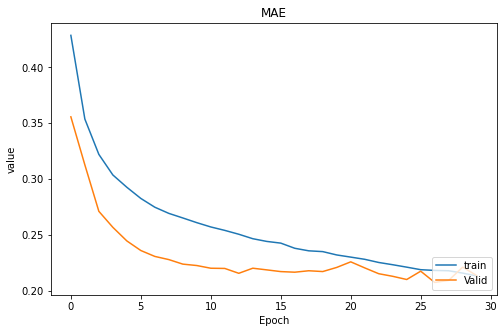

In [266]:
plt.figure(figsize=(8, 5))
plt.title('MAE')
plt.plot(history3.history['mean_absolute_error'], label='train')
plt.plot(history3.history['val_mean_absolute_error'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(loc='lower right')
plt.show()

In [267]:
mytest3 = test_data.iloc[8:]   

In [268]:
myDim3 = np.expand_dims(mytest3, axis=0) 

In [269]:
predictions3 = model3.predict(myDim3)  

In [270]:
temp0 = predictions3.shape[0]    
temp1 = predictions3.shape[1]   
temp2 = predictions3.shape[2]    
p3 = predictions3.reshape((temp1, temp0 * temp2))  
p3.shape 

(4813, 1)

In [271]:
norm3 = (p3 * TempTrain_std[0]) + TempTrain_mean[0]  
                                                    
norm3.shape

(4813, 1)

In [272]:
res3 = norm3.flatten()    
myres3 = zip()            
finalRes3 = []           
myres3 = zip(mytest3.iloc[:,0].index , res3)     
finalRes3 = list(myres3)                         
model3 = pd.DataFrame(finalRes3, columns = ['id', 'prediction']) 
model3.head()                                 

,id,prediction
0,43391,3541.485840
1,43392,3730.816162
2,43393,3981.507324
3,43394,4277.433594
4,43395,4538.318359


In [273]:
model3.to_csv('kaggle3.csv', index=False)    

## Model 4 Using 1D Convolutional + RNN

In [367]:
from keras.layers import Conv1D,MaxPooling2D,Flatten
model4 = Sequential()                            
model4.add(Conv1D(128, 1, activation='linear'))   
model4.add(LSTM(64, return_sequences=True))      
model4.add(Conv1D(128, 1, activation='linear'))   
model4.add(LSTM(64, recurrent_dropout = 0.1, return_sequences=True))       
model4.add(Dense(32, activation='linear'))        
model4.add(Dense(1))                             

In [365]:
early_stopping4 = tf.keras.callbacks.EarlyStopping(    
           monitor='val_loss',patience=10, mode='min')  

In [368]:
model4.compile(loss=tf.losses.MeanSquaredError(),       
                optimizer=tf.optimizers.RMSprop(),      
                metrics=[tf.metrics.MeanAbsoluteError()])      

In [369]:
print('Input shape:', window.example[0].shape)                
print('Output shape:', model4(window.example[0]).shape)     

Input shape: (32, 6, 9)
Output shape: (32, 6, 1)


In [370]:
history4 = model4.fit(window.train, epochs = 30,batch_size = 64,  
           validation_data=window.val, callbacks=[early_stopping4]) 

Epoch 1/30
1055/1055 [==============================] - 7s 6ms/step - loss: 0.4338 - mean_absolute_error: 0.4874 - val_loss: 0.3645 - val_mean_absolute_error: 0.4541
Epoch 2/30
1055/1055 [==============================] - 6s 6ms/step - loss: 0.3607 - mean_absolute_error: 0.4266 - val_loss: 0.3244 - val_mean_absolute_error: 0.4179
Epoch 3/30
1055/1055 [==============================] - 7s 6ms/step - loss: 0.3242 - mean_absolute_error: 0.3976 - val_loss: 0.2921 - val_mean_absolute_error: 0.3928
Epoch 4/30
1055/1055 [==============================] - 7s 7ms/step - loss: 0.3034 - mean_absolute_error: 0.3808 - val_loss: 0.2738 - val_mean_absolute_error: 0.3790
Epoch 5/30
1055/1055 [==============================] - 7s 6ms/step - loss: 0.2906 - mean_absolute_error: 0.3696 - val_loss: 0.2581 - val_mean_absolute_error: 0.3673
Epoch 6/30
1055/1055 [==============================] - 7s 6ms/step - loss: 0.2818 - mean_absolute_error: 0.3614 - val_loss: 0.2473 - val_mean_absolute_error: 0.3580
Epoc

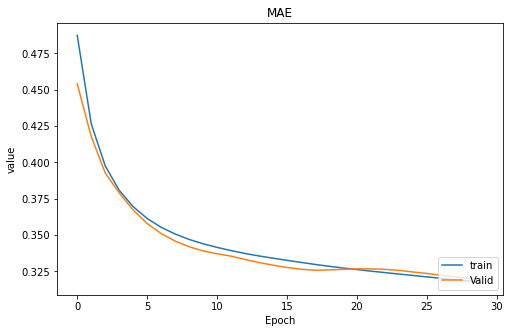

In [373]:
# plot the Mean absolute error between training and testing
plt.figure(figsize=(8, 5))
plt.title('MAE')
plt.plot(history4.history['mean_absolute_error'], label='train')
plt.plot(history4.history['val_mean_absolute_error'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(loc='lower right')
plt.show()

In [374]:
mytest4 = test_data.iloc[8:]  

In [375]:
myDim4 = np.expand_dims(mytest4, axis=0) 

In [376]:
predictions4 = model4.predict(myDim4) 

In [378]:
temp0 = predictions4.shape[0]    
temp1 = predictions4.shape[1]   
temp2 = predictions4.shape[2]    
p4 = predictions4.reshape((temp1, temp0 * temp2))  
p4.shape 

(4813, 1)

In [379]:
norm4 = (p4 * TempTrain_std[0]) + TempTrain_mean[0]  
                                                     
norm4.shape

(4813, 1)

In [380]:
res4 = norm4.flatten()         
myres4 = zip()               
finalRes4 = []                  
myres4 = zip(mytest4.iloc[:,0].index , res4)          
finalRes4 = list(myres4)                               
model4 = pd.DataFrame(finalRes4, columns = ['id', 'prediction']) 
model4.head()                    

,id,prediction
0,43391,2529.539795
1,43392,5450.198242
2,43393,3678.681396
3,43394,3806.701660
4,43395,4007.426758


In [381]:
model4.to_csv('kaggle4.csv', index=False)    

## Model 5 Using 1D convolutional + GRU

In [465]:
from keras.layers import Conv1D,MaxPooling2D,Flatten, GRU
model5 = Sequential()                            
model5.add(Conv1D(128, 1, activation='linear'))   
model5.add(GRU(64,return_sequences=True))        
model5.add(Conv1D(64, 1, activation='linear'))   
model5.add(GRU(32, recurrent_dropout = 0.2, return_sequences=True))  
model5.add(Dense(32, activation='linear'))      
model5.add(Dense(1))                            

In [466]:
early_stopping5 = tf.keras.callbacks.EarlyStopping(     
              monitor='val_loss',patience=10,mode='min') 

In [467]:
model5.compile(loss=tf.losses.MeanSquaredError(),    
                optimizer=tf.optimizers.RMSprop(),   
                metrics=[tf.metrics.MeanAbsoluteError()])  

In [468]:
print('Input shape:', window.example[0].shape)          
print('Output shape:', model5(window.example[0]).shape)

Input shape: (32, 6, 9)
Output shape: (32, 6, 1)


In [451]:
history5 = model5.fit(window.train, epochs=30, batch_size = 64, 
  validation_data = window.val, callbacks=[early_stopping5]) 

Epoch 1/30
1055/1055 [==============================] - 8s 8ms/step - loss: 0.4393 - mean_absolute_error: 0.4897 - val_loss: 0.3992 - val_mean_absolute_error: 0.4864
Epoch 2/30
1055/1055 [==============================] - 9s 8ms/step - loss: 0.3468 - mean_absolute_error: 0.4191 - val_loss: 0.3277 - val_mean_absolute_error: 0.4340
Epoch 3/30
1055/1055 [==============================] - 9s 9ms/step - loss: 0.3089 - mean_absolute_error: 0.3878 - val_loss: 0.2932 - val_mean_absolute_error: 0.4113
Epoch 4/30
1055/1055 [==============================] - 9s 9ms/step - loss: 0.2909 - mean_absolute_error: 0.3714 - val_loss: 0.2743 - val_mean_absolute_error: 0.3934
Epoch 5/30
1055/1055 [==============================] - 10s 9ms/step - loss: 0.2802 - mean_absolute_error: 0.3617 - val_loss: 0.2625 - val_mean_absolute_error: 0.3817
Epoch 6/30
1055/1055 [==============================] - 10s 9ms/step - loss: 0.2734 - mean_absolute_error: 0.3555 - val_loss: 0.2536 - val_mean_absolute_error: 0.3724
Ep

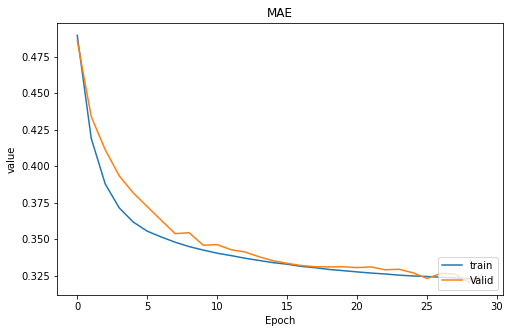

In [452]:
plt.figure(figsize=(8, 5))
plt.title('MAE')
plt.plot(history5.history['mean_absolute_error'], label='train')
plt.plot(history5.history['val_mean_absolute_error'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(loc='lower right')
plt.show()

In [469]:
mytest5 = test_data.iloc[8:]  

In [470]:
myDim5 = np.expand_dims(mytest5, axis=0) 

In [472]:
predictions5 = model5.predict(myDim5)   
predictions5.shape

(1, 4813, 1)

In [473]:
temp0 = predictions5.shape[0]    
temp1 = predictions5.shape[1]    
temp2 = predictions5.shape[2]    
p5 = predictions5.reshape((temp1, temp0 * temp2))  
p5.shape 

(4813, 1)

In [474]:
norm5 = (p5 * TempTrain_std[0]) + TempTrain_mean[0]   
                                                     
norm5.shape

(4813, 1)

In [475]:
res5 = norm5.flatten()          
myres5 = zip()                  
finalRes5 = []                  
myres5 = zip(mytest5.iloc[:,0].index , res5)        
finalRes5 = list(myres5)                             
model5 = pd.DataFrame(finalRes5, columns = ['id', 'prediction']) 
model5.head()                   

,id,prediction
0,43391,3041.578857
1,43392,2894.284180
2,43393,3006.456543
3,43394,2641.798340
4,43395,2446.177490


In [476]:
model5.to_csv('kaggle5.csv', index=False) 